In [1]:
import os
import glob
import pickle
import sys  

sys.path.insert(0, '../py')
from graviti import *

from numpy.linalg import norm
import numpy as np


import pandas as pd

import timeit
import multiprocessing
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

In [2]:
#frequency = int(sys.argv[1]) # how often to pick a nuclei as a seed = size of the covd sample nuclei
#dirpath = sys.argv[2] # the full path to the sample directory

frequency = 10 # how often to pick a nuclei as a seed = size of the covd sample nuclei
dirpath = '/home/garner1/Work/dataset/tcga_polygons/LUAD/TCGA-75-5146-01Z-00-DX1.4958A631-7E6F-4FBB-A1C3-B8F8368D46C5.svs.tar.gz'

In [3]:
sample = os.path.basename(dirpath).split(sep='.')[0]; print(sample)

print('Loading the data')
df = pd.DataFrame()
fovs = glob.glob(dirpath+'/*_polygon/*.svs/*.csv.morphometrics.pkl')

print('There are '+str(len(fovs))+' FOVs')
for fov in fovs: # for each fov
    data = pd.read_pickle(fov)
    df = df.append(data, ignore_index = True)

df['area'] = df['area'].astype(float) # convert to float this field
df['circularity'] = 4.0*np.pi*df['area'] / (df['perimeter']*df['perimeter']) # add circularity

df = df.head(n=10000) # hard-coded downsize for memory issues 

numb_nuclei = df.shape[0] 
print(str(numb_nuclei)+' nuclei')

size = numb_nuclei//frequency
fdf = df.sample(n=size,random_state=1234) #!!!hard-coded random state 
print('We consider '+str(size)+' descriptors')

centroids = df.columns[:2];# print(centroids)
X = df[centroids].to_numpy() # the full array of position
n_neighbors = frequency + 10 # the number of nuclei in each descriptor
print('Characterizing the neighborhood')
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',n_jobs=-1).fit(X) 
distances, indices = nbrs.kneighbors(X) 

# Parallel generation of the local covd
data = df.to_numpy()
print('Generating the descriptor')
num_cores = multiprocessing.cpu_count() # numb of cores
node_vec_switch_centroid = Parallel(n_jobs=num_cores)(
    delayed(covd_parallel_sparse)(node,data,indices) for node in tqdm(list(fdf.index))
    )

nodes_with_covd = [l[0] for l in node_vec_switch_centroid if l[2] == 1] # list of nodes with proper covd
nodes_wo_covd = [l[0] for l in node_vec_switch_centroid if l[2] == 0] # list of nodes wo covd
fdf['covd'] = [0 for i in range(fdf.shape[0])]
fdf.loc[nodes_with_covd,'covd'] = 1 # identify nodes with covd in dataframe
fdf.loc[nodes_wo_covd,'covd'] = 0 # identify nodes wo covd in dataframe    
print('There are '+str(len(nodes_with_covd))+' nodes with covd properly defined')

# Add the descriptor feature to fdf
fdf["descriptor"] = ""; fdf["descriptor"].astype(object)
for item in node_vec_switch_centroid:
    descriptor = item[1]
    centroid = item[3]
    node = item[0]
    fdf.at[node,'descriptor'] = pd.Series(descriptor).values

# Generate the descriptor array
descriptor = np.zeros((len(nodes_with_covd),node_vec_switch_centroid[0][1].shape[0]))
r_idx = 0
for index, row in fdf.iterrows():
    if row['covd']:
        descriptor[r_idx,:] = row['descriptor']
        r_idx += 1

mean_covd = np.mean(descriptor,axis=0) # evaluate the barycenter descriptor

delta = descriptor-mean_covd # evaluate the distance vec of the barycenter from each descriptor
distance_from_barycenter = norm(delta,axis=1) # take the eucledean norm

# Update the dataframe
fdf.loc[nodes_with_covd,'heterogeneity'] = distance_from_barycenter
fdf.loc[nodes_wo_covd,'heterogeneity'] = np.nan

TCGA-75-5146-01Z-00-DX1
Loading the data
There are 20 FOVs
10000 nuclei
We consider 1000 descriptors
Characterizing the neighborhood


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating the descriptor


100%|██████████| 1000/1000 [00:37<00:00, 26.47it/s]


There are 990 nodes with covd properly defined


In [4]:
filename = dirpath+'/'+sample+'.nuclei'+str(numb_nuclei)+'.size'+str(size)+'.covdNN'+str(n_neighbors)+'.features.pkl'
fdf.to_pickle(filename)

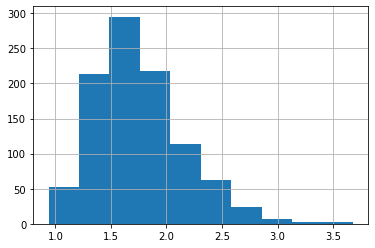

In [5]:
# Show contour plot
N = 10
filename = 'test.sum'
contourPlot(fdf[(fdf['covd']==True) & (fdf['heterogeneity']>0)],N,np.sum,filename)
 # Show the distribution
fdf['heterogeneity'].hist(bins=10)